In [1]:
import numpy as np
import pandas as pd
import toolz as tz
import itertools as it
import functools as ft

import rospy
from rosh import Bagy


from robot_wardrive.msg import SignalLocation, PingLocation

# Load Data

In [40]:
ls patrolling_2015-06-08/

2015-06-08-10-52_google.bagy  2015-06-08-10-52_mpc.bagy  2015-06-08-10-52_signal_location.bagy


In [73]:
msgs = None
columns=['secs', 'x', 'y', 'delay']
# bagy_name = '2015-05-28_signal_location_trunkated.bagy'
bagy_name = 'test_bagy_mpc.bagy'
bagy_name = 'patrolling_2015-06-08/2015-06-08-10-52_google.bagy'
with Bagy(bagy_name, 'r', PingLocation) as bagy:
    msgs = pd.DataFrame([(msg.header.stamp.secs, msg.pose.position.x, msg.pose.position.y, msg.delay) for msg in bagy], columns=columns)
                

In [74]:
msgs.to_csv('2015-06-08-10-52_google.csv')

In [43]:
msgs.head()

,secs,x,y,delay
0,1433753551,0.00000,0.000000,0.882
1,1433753552,15.49182,32.360715,0.904
2,1433753552,15.49182,32.360715,0.902
3,1433753553,15.49182,32.360715,0.923
4,1433753553,15.49182,32.360715,0.883


In [44]:
msgs.describe()

,secs,x,y,delay
count,1.161700e+04,11617.000000,11617.000000,11617.000000
mean,1.433757e+09,13.468391,39.556542,3.683483
std,1.829834e+03,1.330257,20.067468,25.393861
min,1.433754e+09,0.000000,0.000000,0.755000
25%,1.433755e+09,12.522579,33.668992,0.886000
50%,1.433757e+09,13.979883,33.668992,0.919000
75%,1.433758e+09,13.979883,33.668992,1.120000
max,1.433760e+09,19.220119,109.002314,1008.000000


# Plots

## hexbin

Populating the interactive namespace from numpy and matplotlib


(26, 110)

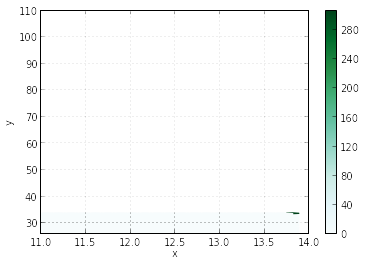

In [7]:
%pylab inline

msgs.plot(kind='hexbin', x='x', y='y', gridsize=100, reduce_C_function=np.max)
plt.xlim((11,14))
plt.ylim((26,110))


## Scatter

(26, 110)

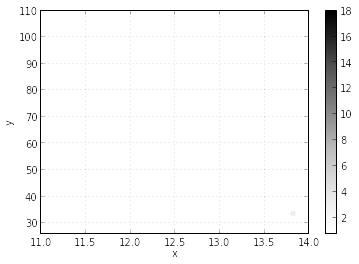

In [9]:
msgs.plot(kind='scatter', x='x', y='y', c='delay', linewidth=0)
plt.xlim((11,14))
plt.ylim((26,110))

## Colormesh

In [10]:
# plt.pcolormesh(msgs.x.values, msgs.y.values, msgs.link.values)

#Rounding 

In [11]:
rounded = msgs.apply(np.round, decimals=1)

In [12]:
rounded.groupby(['x', 'y']).mean().reset_index(inplace=True)

In [13]:
#rounded['link'] = rounded['link'] * -1

## Plot rounded

In [70]:
# Set image limits
extent=[min(rounded.x - 6.55), max(rounded.x + 5.55),
       min(rounded.y - 4.6),max(rounded.y + 11.4)]

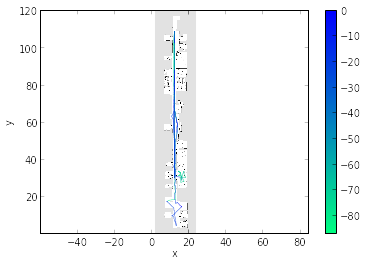

In [71]:
rounded.plot(kind='scatter', x='x', y='y', c='link',
             s=0.15, linewidth=0,
             grid=None, cmap="winter_r")  # cmap=*_r is reversed version of the cmap
img = plt.imread('roboticslab_complete_clean.png')
implot = plt.imshow(img, extent=extent, cmap='Greys_r')
axes().set_aspect('equal', 'datalim')
plt.grid(b=None)
plt.savefig('wifi_coverage.pdf', grid=None, transparent=True, dpi=300)

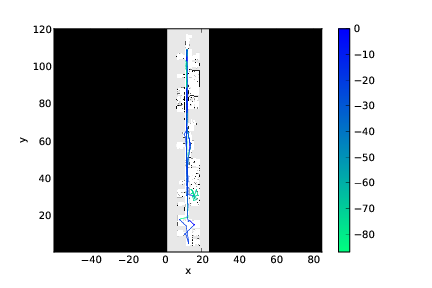

In [69]:
from wand.image import Image as WImage
img = WImage(filename='wifi_coverage.pdf')
img

# Trying Meshgrid 

In [20]:
xx, yy = np.meshgrid(rounded.x, rounded.y)
print xx, yy

ValueError: array is too big.

In [26]:
df = pd.DataFrame(rounded.link, index=rounded.x, columns=rounded.y)


# Timestamp vs delay


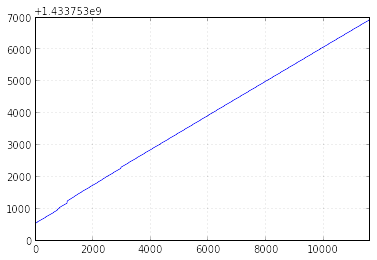

In [45]:
msgs.secs.plot()

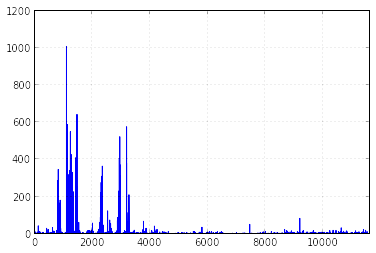

In [47]:
msgs.delay.plot()

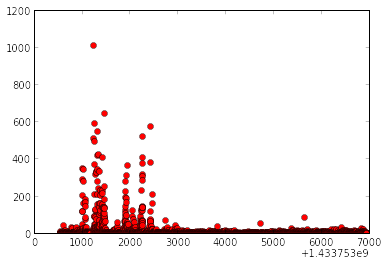

In [49]:
plt.plot(msgs.secs, msgs.delay, 'ro')

In [51]:
msgs.secs.rolling_mean(2)

AttributeError: 'Series' object has no attribute 'rolling_mean'

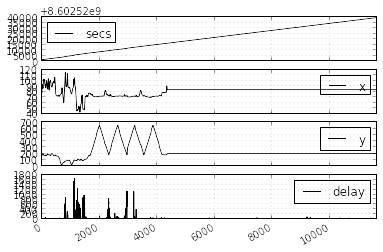

In [56]:
pd.rolling_sum(msgs, 6).plot(subplots=True)
plt.savefig('test.pdf', ls=0.1)

In [58]:
msgs_patrolling = msgs[0:5500]
msgs_docked = msgs[6000:]

In [72]:
pd.rolling_sum(msgs_docked, 6).plot(subplots=True)
plt.savefig('test_docked.pdf', ls=0.1)

In [69]:
%pylab qt

Populating the interactive namespace from numpy and matplotlib


In [70]:
pd.rolling_sum(msgs_patrolling, 6).plot(subplots=True)
plt.savefig('test_patrolling.pdf', ls=0.1)

In [71]:
pd.rolling_sum(msgs_patrolling.secs, 6).plot(kind='scatter')

ValueError: Invalid chart type given scatter

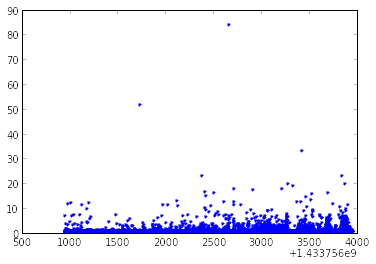

In [63]:
plt.plot(msgs_docked.secs, msgs_docked.delay, '.')

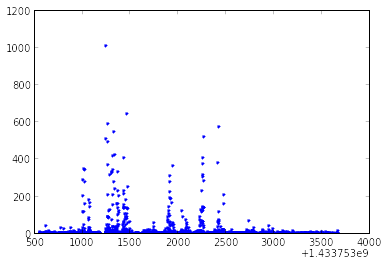

In [65]:
plt.plot(msgs_patrolling.secs, msgs_patrolling.delay, '.')